**Подготовка colab notebook**

1.Скопируйте этот colab (go to File-->Save copy in Drive)

2.В открывшемся новом colab:

переименуйте название следующим образом "Тестовое задание ShiftLab 2022 Computer Vision [ваше имя фамилия].ipynb" 

например,
"Тестовое задание ShiftLab 2022 Computer Vision Иван Иванов.ipynb"


#Необходимо создать и обучить multi-output классификатор изображений







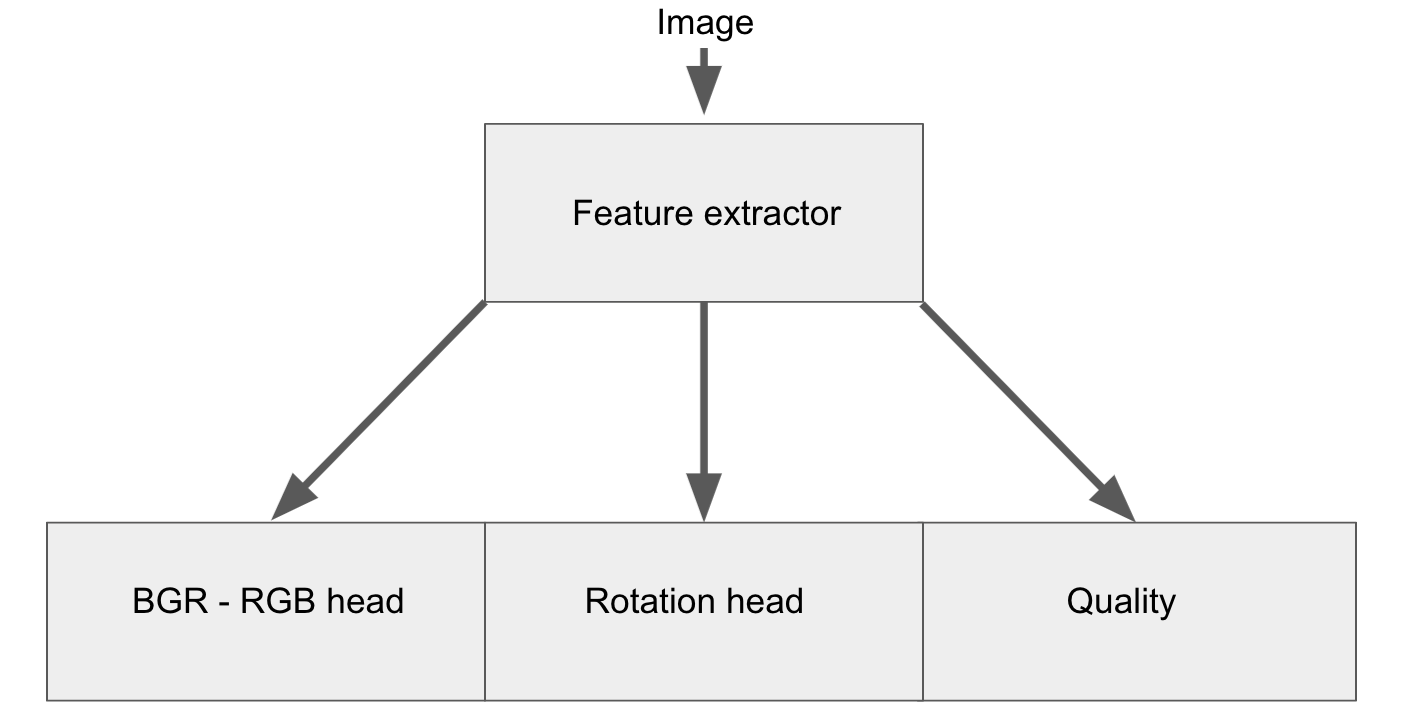

# На вход в классификатор подается изображение, на выходе должны быть вероятности для следующих классов:
### Выход качество: 

классы: 

1. Blur - фото смазано 

2. Torch -  фото засвечено

3. Sharp - фото хорошего качества, резкое

### Выход поворот:

классы: 

1. Поворот отсутствует 0 градусов

2. Поворот по часовой стрелке на 90 градусов

3. Поворот против часовой стрелке на 90 градусов

4. Перевернутое фото 180 градусов


### Выход  RGB-BGR:

классы:

1. RGB

2. BGR




 

## Особенности задания

1. Можно использовать любые открытые датасеты. Ниже найдете пример датасета.
2. Решение должно быть именно Вашим, уникальным и не повторяться с другими участниками.
4. Можно использовать любой удобный фреймворк (Pytorch, FastAI, Keras, Tensorflow)
5.Назовите папку для датасета DATASET_DIR в следующем формате : первая буква вашего имени,ваша фамилия, название датасета например : v_ivanov_images_dataset. Так мы сможем быстрее проверить решение


# Как начать


## Загрузка датасета с kaggle

In [1]:
# set up kaggle json in colab and download the dataset
# make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/YOURDISPLAYNAME/account

! pip install -q kaggle

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# example downloading dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [00:25<00:00, 103MB/s] 
100% 1.49G/1.49G [00:25<00:00, 61.8MB/s]


Dataset was cloned after loading, remove extra dirs. And rename dir with dataset will be used.

In [3]:
!mv /content/blur_dataset_scaled /content/a_arestov_images_dataset
!rm -rf /content/defocused_blurred
!rm -rf /content/motion_blurred
!rm -rf /content/sharp

## Labels dict

In [ ]:
dataset_dict = {
    'quality': {0: 'blur',   1: 'torch',   2:'sharp'},
    'angle':   {0:  '0',     1: '90r',     2: '90l',   3: '180'},
    'format':  {0: 'rgb',    1: 'bgr'}
    }

dataset_dict['quality_alias'] = dict((g, i) for i, g in dataset_dict['quality'].items())
dataset_dict['angle_alias'] = dict((r, i) for i, r in dataset_dict['angle'].items())
dataset_dict['format_alias'] = dict((f, i) for i, f in dataset_dict['format'].items())

In [ ]:
# remove extra dirs
# !rm -rf /content/a_arestov_images_dataset/blur_to_gbr

# copy dir
# !cp -R /content/a_arestov_images_dataset/blur /content/a_arestov_images_dataset/blur_to_gbr

# Prepare data

## Create 'torched' sample

https://imgaug.readthedocs.io/en/latest/source/overview/imgcorruptlike.html - fog & freeze & brightness

https://imgaug.readthedocs.io/en/latest/source/overview/weather.html

**Summary**: i didn't manage to find any mention of sun glares or whatever applied in python, so i decided to blend sharp pictures and motion blur ones. Photos into dataset are triplet, so we can find pair 'sharp-mot_blur' for every picture (due to there are strictly 350 per triplet) with just sorting content of irs by name (fortunately, images have similar names).

Example is below. 

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.lib.display import join
import shutil 
from tqdm import tqdm

### Example of image blending

In [17]:
path = '/content/a_arestov_images_dataset/'
mot_blur_path = path + 'motion_blurred/'
sharp_path = path + 'sharp/'

In [41]:
n = 124
print(sorted(os.listdir('/content/a_arestov_images_dataset/sharp'))[n])
print(sorted(os.listdir('/content/a_arestov_images_dataset/motion_blurred'))[n])

211_SAMSUNG-GALAXY-7-NEO_S.jpg
211_SAMSUNG-GALAXY-7-NEO_M.jpg


In [69]:
n = 11
img1 = Image.open(mot_blur_path + \
                  str( sorted(os.listdir(mot_blur_path))[n] )).resize((500,300))
img2 = Image.open(sharp_path + \
                  str( sorted(os.listdir(sharp_path))[n] )).resize((500,300)) # normal sharp
img3 = Image.blend(img1, img2, 1.7)

10_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg
10_ASUS-ZENFONE-LIVE-ZB501KL_S.jpg


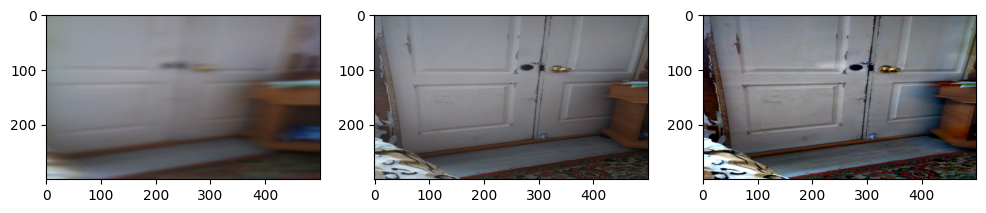

In [70]:
print(sorted(os.listdir(mot_blur_path))[n])
print(sorted(os.listdir(sharp_path))[n])
fig, ax = plt.subplots(1,3, figsize=(12, 9))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3) # product

### Blending

Enumerate 'sharp' dir to expand our sample with 'torch' images:

In [71]:
!mkdir /content/a_arestov_images_dataset/torch

In [72]:
!mkdir /content/a_arestov_images_dataset/torch
source_mot_blur = path + 'motion_blurred/'
source_sharp = path + 'sharp/'
source_torch = path + 'torch/'

for i, file_name in enumerate(tqdm(os.listdir(source_mot_blur))):
    name, extension = os.path.splitext(file_name)
    blure_img = Image.open(source_mot_blur + \
                  str( sorted(os.listdir(mot_blur_path))[i] ))
    sharp_img = Image.open(source_sharp + \
                  str( sorted(os.listdir(sharp_path))[i] )) # normal sharp
    torch_img = Image.blend(blure_img, sharp_img, 1.7) 
    
    # save and label images accoring 'torch' '0 deg' 'BGR'
    torch_img.save(f'{source_torch}/' + f'1_0_1_{i}'+f'{extension}')

100%|██████████| 350/350 [01:47<00:00,  3.27it/s]


In [74]:
!rm -rf /content/a_arestov_images_dataset/motion_blurred
len(os.listdir(source_torch))

350

## Blur branch

In [ ]:
# for splitting 'defocused_blurred' and 'motion_blurred' (ну мало ли)
'''
from IPython.lib.display import join
import shutil 
from tqdm import tqdm

path = '/content/a_arestov_images_dataset/'
blur_dir = 'blur'
os.makedirs(os.path.join(path+blur_dir), exist_ok=True)

source_dir = os.path.join(path, 'defocused_blurred')
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    dest_dir = os.path.join(path+blur_dir) 
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

source_dir = os.path.join(path, 'motion_blurred')
for j, file_name in enumerate(tqdm(os.listdir(source_dir))):
    dest_dir = os.path.join(path+blur_dir) 
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
'''

In [ ]:
!mv /content/a_arestov_images_dataset/defocused_blurred /content/a_arestov_images_dataset/blur

100%|██████████| 350/350 [00:00<00:00, 31534.09it/s]


Rename pictures and put labels into name:

In [76]:
def put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        os.rename(source_dir+'/'+file_name, f'{source_dir}/'+ f'{label}{i}'+f'{extension}') 

Put labels on 'blur' and 'sharp' 'not rotated (0 deg)' 'BGR' images:

In [77]:
put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_') # blur
put_img_label(source_dir = os.path.join(path, 'sharp'), label = '2_0_1_') # sharp

100%|██████████| 350/350 [00:00<00:00, 26893.95it/s]


Apply the sample to blur RGB images (and translate to RGB, ofc):

In [79]:
def to_rgb(source_dir = os.path.join(path, 'blur'), label = '0_0_0_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        img = Image.open(source_dir+'/'+file_name)
        b, g, r = img.split()
        image = Image.merge("RGB", (r, g, b))
        image.save(f'{source_dir}/' + f'{label}{i}'+f'{extension}')

In [80]:
to_rgb(source_dir = os.path.join(path, 'blur'), label = '0_0_0_') # blur 0deg rgb
to_rgb(source_dir = os.path.join(path, 'sharp'), label = '2_0_0_') # sharp 0deg rgb

100%|██████████| 350/350 [01:03<00:00,  5.52it/s]


In [85]:
print((len(os.listdir('/content/a_arestov_images_dataset/blur'))))
print((len(os.listdir('/content/a_arestov_images_dataset/sharp'))))

700
700


## Sharp branch

Share the sample with sharp RGB images:

In [ ]:
source_dir = os.path.join(path, 'sharp')

for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    name, extension = os.path.splitext(file_name)
    img = Image.open(source_dir+'/'+file_name)
    b, g, r = img.split()
    image = Image.merge("RGB", (r, g, b))
    image.save(f'{source_dir}/' + f'2_0_0_{i}'+f'{extension}')

100%|██████████| 350/350 [01:11<00:00,  4.92it/s]


In [ ]:
print(str(len(os.listdir(source_dir))) + ' in ' + source_dir)

700 in /content/a_arestov_images_dataset/sharp


# Модель
Напишите здесь свою модель и визуализацию данных. 
Архитектура любая на ваше усмотрение (CNN, Transformers, SE blocks)
Используйте необходимые метрики, матрицу ошибок для анализа модели

Проверьте модель на тестовых данных 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
pic = Image.open(r'/content/motion_blurred/0_IPHONE-SE_M.JPG')

In [ ]:
pic.size

(1536, 2048)

# Пример датасета 
https://www.kaggle.com/kwentar/blur-dataset









































































































# Контакты

Вопросы можно задать в 
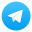


@JI_411

@dragynir


Удачи в выполнении задания!